This notebook is to clean, explore, and model the Ames Housing Dataset for the Kaggle getting started competition ["House Prices - Advanced Regression Techniques."](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview). It includes data for residential home sales in Ames, Iowa. The goal of this competition is to predict the home price.

First thing, of course, we need to import the training data. Then we can start looking at it to learn more about it.

In [2]:
import pandas as pd

df = pd.read_csv('train.csv', index_col='Id')

display(df.head())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Glancing at the "Alley" column, it looks like observations without data are already `NaN` for us. We'll look more closely later on, but this is promising in terms of how much effort it will take to clean the data.

In [3]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

None

However, do note that some columns have missing values. There are 1,460 records in this data set and 80 columns.

I noticed when looking at the [codebook](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=data_description.txt) that "MSZoning" could possibly include non-residential classifications. 

> MSZoning: Identifies the general zoning classification of the sale.

>       A    Agriculture
>       C    Commercial
>       FV    Floating Village Residential
>       I    Industrial
>       RH    Residential High Density
>       RL    Residential Low Density
>       RP    Residential Low Density Park 
>       RM    Residential Medium Density


I wonder how many of them are in this dataset?

In [4]:
df['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [5]:
df['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

The vast majority of the data is zoned for residential, low density housing. There are some others and even some commercial properties.

Since our target variable is the "SalePrice", I want to get some information about it.

In [6]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Somehow I've always been under the impression that there is a seasonality to house prices. They are most expensive in the summer and least expensive in the winter. I'm going to create some columns to sort them out by season.

In [7]:
import numpy as np

df['SpringSale'] = np.where(df['MoSold'].isin([3,4,5]),1,0)
df['SummerSale'] = np.where(df['MoSold'].isin([6,7,8]),1,0)
df['AutumnSale'] = np.where(df['MoSold'].isin([9,10,11]),1,0)
df['WinterSale'] = np.where(df['MoSold'].isin([12,1,2]),1,0)

display(df[['MoSold','SpringSale','SummerSale','AutumnSale','WinterSale']].head(10))

,MoSold,SpringSale,SummerSale,AutumnSale,WinterSale
Id,,,,,
1,2,0,0,0,1
2,5,1,0,0,0
3,9,0,0,1,0
4,2,0,0,0,1
5,12,0,0,0,1
6,10,0,0,1,0
7,8,0,1,0,0
8,11,0,0,1,0
9,4,1,0,0,0


A couple of other things I noticed when looking through the data was that "CentralAir" only included yes and no values, so could easily be a boolean.

Also, there isn't a column for total square feet, so I'm going to put one together. Actually, several could be useful, depending on which parts of the house we care about.

In [8]:
df['CentralAirBool'] = np.where(df['CentralAir']=='Y',1,0)

In [9]:
df['TotalLivAreaSF'] = df['1stFlrSF'] + df['2ndFlrSF']
df['TotalLivPlusGarageSF'] = df['TotalLivAreaSF'] + df['GarageArea']
df['TotalLivPlusBsmtSF'] = df['TotalLivAreaSF'] + df['TotalBsmtSF']
df['TotalSF'] = df['TotalLivAreaSF'] + df['TotalBsmtSF'] + df['GarageArea']

In [10]:
df['TotalSF'].describe()

count     1460.000000
mean      3040.028767
std        958.651371
min        334.000000
25%       2388.000000
50%       2934.000000
75%       3570.750000
max      13170.000000
Name: TotalSF, dtype: float64

The 75th percentile of home size is 3570 square feet, but the max is 13,170? That's a huge house! Let's dig into this a little more. Is this an outlier? Are there a few huge houses?

In [11]:
print(f"95th percentile: {df['TotalSF'].quantile(0.95)}")
print(f"99th percentile: {df['TotalSF'].quantile(0.99)}")

95th percentile: 4712.9
99th percentile: 5600.660000000002


Hm ... even the 99th percentile isn't anywhere near 13,170.

In [12]:
display(df['TotalLivAreaSF'].describe(), df['TotalLivPlusBsmtSF'].describe())

count    1460.000000
mean     1509.619178
std       521.163523
min       334.000000
25%      1123.750000
50%      1458.000000
75%      1775.250000
max      5642.000000
Name: TotalLivAreaSF, dtype: float64

count     1460.000000
mean      2567.048630
std        821.714421
min        334.000000
25%       2009.500000
50%       2474.000000
75%       3004.000000
max      11752.000000
Name: TotalLivPlusBsmtSF, dtype: float64

I think one house just has a huge basement? Let's just look at the houses above the 99th percentile.

In [13]:
df[df['TotalSF']>5600][['TotalLivAreaSF','TotalLivPlusGarageSF','TotalLivPlusBsmtSF','TotalSF']].sort_values('TotalSF')

,TotalLivAreaSF,TotalLivPlusGarageSF,TotalLivPlusBsmtSF,TotalSF
Id,,,,
179,2234,3400,4450,5616
333,1629,2509,4835,5715
225,2392,3360,4784,5752
770,3279,4120,4929,5770
305,3493,4363,4963,5833
799,3140,3960,5066,5886
1354,3238,3904,5271,5937
1374,2633,3437,5266,6070
441,2402,3074,5496,6168


It _is_ specifically one house! Out of curiosity, I'm going to compare summary statistics for home price with and without this outlier and another that we will see later seems rather large given the sale price.

In [35]:
price_with_outliers = df['SalePrice']
price_without_outliers = df[df['TotalSF'] < 8600]['SalePrice']

print(f"Full dataset: \n{price_with_outliers.describe()}")
print("")
print(f"Outliers removed: \n{price_with_outliers.describe()}")

Full dataset: 
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Outliers removed: 
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [36]:
sf_with_outliers = df['TotalSF']
sf_without_outliers = df[df['TotalSF'] < 8600]['TotalSF']

print(f"Full dataset: \n{sf_with_outliers.describe()}")
print("")
print(f"Outliers removed: \n{sf_without_outliers.describe()}")

Full dataset: 
count     1460.000000
mean      3040.028767
std        958.651371
min        334.000000
25%       2388.000000
50%       2934.000000
75%       3570.750000
max      13170.000000
Name: TotalSF, dtype: float64

Outliers removed: 
count    1458.000000
mean     3029.200274
std       909.810501
min       334.000000
25%      2388.000000
50%      2932.500000
75%      3569.500000
max      7685.000000
Name: TotalSF, dtype: float64


Culling the outliers does tighten up the standard deviation a bit, but doesn't have much effect on the summary statistics aside from the max.

I'm concerned that something is wrong with the basement size data. We'll see this more later in visualization. However, I'm going to leave it in. I don't know what the test data looks like, and it's possible that this could provide useful information in the algorithm when the time comes.

Next, I'm going to look at how the price statistics change with the season.

In [14]:
df.groupby('MoSold')['SalePrice'].agg([np.min, np.max, np.median, np.mean])

,amin,amax,median,mean
MoSold,,,,
1,39300,755000,151650,183256.258621
2,93000,320000,173250,177882.000000
3,52500,611657,165250,183253.924528
4,68400,555000,147000,171503.262411
5,37900,430000,154000,172307.269608
6,55993,538000,163000,177395.735178
7,40000,745000,165195,186331.192308
8,64500,426000,174450,184651.827869
9,67000,465000,185900,195683.206349


In [15]:
display(df['MoSold'].value_counts())
df['SoldMayJunJul'] = np.where(df['MoSold'].isin([5,6,7]),1,0)
display(df.groupby('SoldMayJunJul')['SalePrice'].agg([np.min, np.max, np.median, np.mean]))

6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

,amin,amax,median,mean
SoldMayJunJul,,,,
0,34900,755000,165000,182719.951886
1,37900,745000,160000,178919.396527


I'm fascinated. It looks like, while the majority of homes are sold in May, June, and July, that doesn't translate to higher prices during those times. It would be helpful to visualize as well and maybe do some hypothesis testing.

What can we learn about the neighborhoods where these homes are sold?

In [16]:
display(df.pivot_table('SalePrice', index='Neighborhood', columns='YrSold', margins=True))
display(df.pivot_table('SalePrice', index=['Neighborhood', 'MSZoning'], columns='YrSold', margins=True))
display(df.pivot_table('SalePrice', index=['Neighborhood', 'MSSubClass'], columns='YrSold', margins=True))

YrSold,2006,2007,2008,2009,2010,All
Neighborhood,,,,,,
Blmngtn,217087.000000,183350.500000,175447.500000,176720.000000,192000.000000,194870.882353
Blueste,NaN,NaN,151000.000000,124000.000000,NaN,137500.000000
BrDale,96750.000000,113833.333333,95225.000000,118625.000000,88000.000000,104493.750000
BrkSide,112746.666667,135737.500000,121707.142857,134994.117647,96500.000000,124834.051724
ClearCr,199166.666667,236333.333333,208991.500000,169875.000000,246850.000000,212565.428571
CollgCr,199016.406250,213999.933333,187718.055556,192317.769231,203700.000000,197965.773333
Crawfor,196635.181818,198777.578947,254411.111111,180211.111111,296833.333333,210624.725490
Edwards,134403.684211,132588.235294,132473.076923,123855.555556,111445.454545,128219.700000
Gilbert,200250.625000,181967.947368,186000.000000,199955.000000,185500.000000,192854.506329


YrSold                          2006           2007           2008  \
Neighborhood MSZoning                                                
Blmngtn      RL        223478.166667  183350.500000  175447.500000   
             RM        178740.000000            NaN            NaN   
Blueste      RM                  NaN            NaN  151000.000000   
BrDale       RM         96750.000000  113833.333333   95225.000000   
BrkSide      RL        111885.714286  145475.000000  129785.714286   
             RM        113500.000000  126000.000000  113628.571429   
ClearCr      RL        199166.666667  236333.333333  208991.500000   
CollgCr      RL        200407.258065  216844.758621  194759.677419   
             RM        155900.000000  131500.000000  144060.000000   
Crawfor      RH                  NaN  145000.000000            NaN   
             RL        196635.181818  203235.875000  231742.857143   
             RM                  NaN  235000.000000  333750.000000   
Edwards      RH                  NaN   79000.000000            NaN   
             RL        133936.153846  135937.500000  131852.000000   
             RM        135416.666667            NaN  148000.000000   
Gilbert      RL        200250.625000  181967.947368  186000.000000   
IDOTRR       C (all)    71655.500000            NaN   60500.000000   
             RM        105400.000000  118933.333333  104100.000000   
MeadowV      RM        123466.666667  105850.000000   98000.000000   
Mitchel      RL        148100.000000  136731.818182  160722.222222   
             RM        158750.000000            NaN  206300.000000   
NAmes        RH                  NaN  133000.000000  181000.000000   
             RL        138985.454545  143153.846154  150952.204082   
NPkVill      RL                  NaN  141500.000000  140000.000000   
NWAmes       RL        199463.888889  175267.083333  193820.000000   
NoRidge      RL        322333.333333  399730.909091  304750.000000   
NridgHt      RL        305491.882353  310833.111111  343824.909091   
             RM                  NaN            NaN  207000.000000   
OldTown      C (all)             NaN  133900.000000            NaN   
             RL        127497.142857   90675.000000  106250.000000   
             RM        139083.105263  118866.894737  149395.833333   
SWISU        RH        160000.000000  200000.000000  135000.000000   
             RL        120166.666667  175000.000000  141150.000000   
Sawyer       RL        151281.250000  133935.294118  128900.692308   
             RM        125000.000000            NaN            NaN   
SawyerW      RH        113450.000000  144000.000000            NaN   
             RL        181900.000000  215236.363636  184080.000000   
Somerst      FV        186100.153846  218256.800000  221048.571429   
             RL        315000.000000  258235.777778  236323.333333   
StoneBr      RL        365046.666667  279585.200000  245000.000000   
Timber       RL        264485.714286  229470.545455  234361.000000   
Veenker      RL        273333.333333  214900.000000  244000.000000   
All                    182549.458599  186063.151976  177360.838816   

YrSold                          2009           2010            All  
Neighborhood MSZoning                                               
Blmngtn      RL        176720.000000  192000.000000  195879.062500  
             RM                  NaN            NaN  178740.000000  
Blueste      RM        124000.000000            NaN  137500.000000  
BrDale       RM        118625.000000   88000.000000  104493.750000  
BrkSide      RL        160571.428571   96500.000000  133431.250000  
             RM        117090.000000            NaN  116810.000000  
ClearCr      RL        169875.000000  246850.000000  212565.428571  
CollgCr      RL        195037.648649  208758.333333  201858.328571  
             RM        142000.000000  143000.000000  143470.000000  
Crawfor      RH                  NaN            NaN  145000.000000  
             RL      

YrSold                            2006           2007           2008  \
Neighborhood MSSubClass                                                
Blmngtn      20                    NaN            NaN  159895.000000   
             120         217087.000000  183350.500000  191000.000000   
Blueste      160                   NaN            NaN  151000.000000   
BrDale       160          96750.000000  113833.333333   95225.000000   
BrkSide      20                    NaN   39300.000000   72500.000000   
...                                ...            ...            ...   
Veenker      20          275000.000000  199750.000000  162500.000000   
             60                    NaN  294000.000000            NaN   
             80                    NaN  190500.000000            NaN   
             120         270000.000000            NaN  284750.000000   
All                      182549.458599  186063.151976  177360.838816   

YrSold                           2009           2010            All  
Neighborhood MSSubClass                                              
Blmngtn      20                   NaN            NaN  159895.000000  
             120         176720.00000  192000.000000  197056.875000  
Blueste      160         124000.00000            NaN  137500.000000  
BrDale       160         118625.00000   88000.000000  104493.750000  
BrkSide      20                   NaN  116500.000000   76100.000000  
...                               ...            ...            ...  
Veenker      20                   NaN            NaN  222400.000000  
             60                   NaN            NaN  294000.000000  
             80                   NaN            NaN  190500.000000  
             120                  NaN            NaN  279833.333333  
All                      179432.10355  177393.674286  180921.195890  

[145 rows x 6 columns]

I think some graphs would be easier to understand. Let's save this and move along for now.

In [17]:
df.to_csv('train_added_season_sqf.csv')

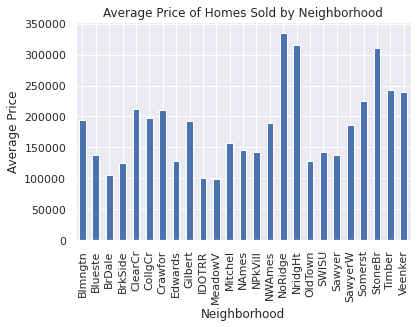

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

price_by_neighborhood = df.groupby('Neighborhood').mean()['SalePrice']
price_by_neighborhood.plot(kind='bar')
plt.ylabel('Average Price')
plt.title('Average Price of Homes Sold by Neighborhood')
plt.show()

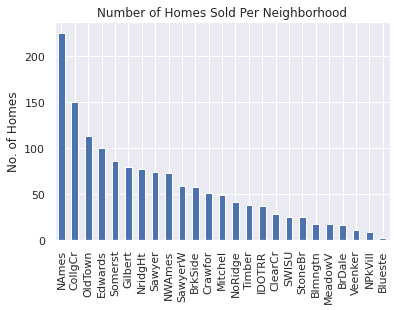

In [52]:
neighborhoods = df['Neighborhood'].value_counts()
neighborhoods.plot(kind='bar')
plt.ylabel('No. of Homes')
plt.title('Number of Homes Sold Per Neighborhood')
plt.show()

The most expensive homes on average were sold in Northridge, Northridge Heights, and Stone Brook, but the most homes were sold in North Ames. 

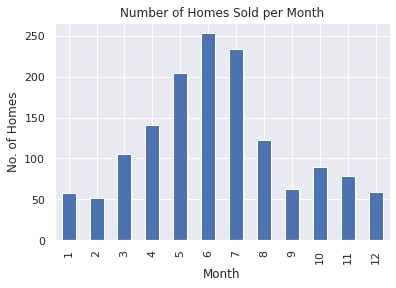

In [53]:
months = df['MoSold'].value_counts()
months.sort_index().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('No. of Homes')
plt.title('Number of Homes Sold per Month')
plt.show()

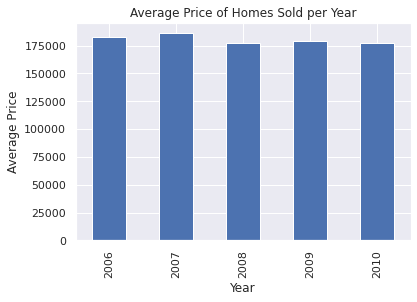

In [54]:
yearprice = df.groupby('YrSold').mean()['SalePrice']
yearprice.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.title('Average Price of Homes Sold per Year')
plt.show()

We can see more homes are sold in late spring and early summer. I thought there might be a trend in homes sold by year due to the housing market crisis, but there isn't much of one.

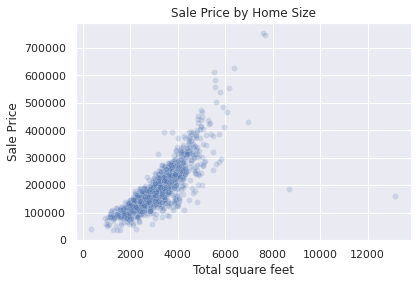

In [58]:
sns.scatterplot(x='TotalSF', y='SalePrice', data=df, alpha=0.2)
plt.title('Sale Price by Home Size')
plt.xlabel('Total square feet')
plt.ylabel('Sale Price')
plt.show()

Here we can see that outlier more clearly, but for the reasons explained above, I'm going to leave it in.

In [23]:
display(df.isna().any())
display(df.isna().sum())

MSSubClass              False
MSZoning                False
LotFrontage              True
LotArea                 False
Street                  False
                        ...  
TotalLivAreaSF          False
TotalLivPlusGarageSF    False
TotalLivPlusBsmtSF      False
TotalSF                 False
SoldMayJunJul           False
Length: 90, dtype: bool

MSSubClass                0
MSZoning                  0
LotFrontage             259
LotArea                   0
Street                    0
                       ... 
TotalLivAreaSF            0
TotalLivPlusGarageSF      0
TotalLivPlusBsmtSF        0
TotalSF                   0
SoldMayJunJul             0
Length: 90, dtype: int64

In [24]:
df['MasVnrType'].replace(['None'], np.nan, inplace=True)

I went through and checked everything - the only column that had something like "None" in it was "MasVnrType," so I'll replace that with NaN.

Then let's save the cleaned version and do some more exploratory analysis and visualization!

In [25]:
df.to_csv('train_added_cleaned.csv')

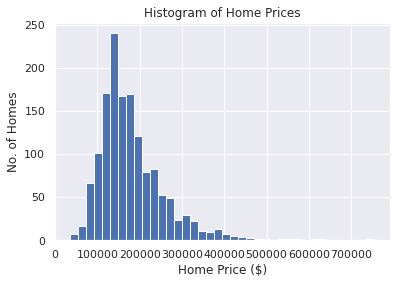

In [38]:
import seaborn as sns

sns.set()

n_bins = int(np.sqrt(df.shape[0]))
plt.hist(df['SalePrice'], bins=n_bins)
plt.xlabel('Home Price ($)')
plt.ylabel('No. of Homes')
plt.title('Histogram of Home Prices')
plt.show()

While most homes fall within the \\$100-200k range, there is an interesting bump around $375,000. The distribution is skewed with a longer tail to the right.

Now I'm going to mess around with boxplots, because they make sense to my brain.

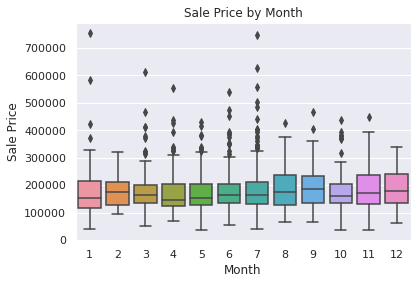

In [59]:
sns.boxplot(x='MoSold', y='SalePrice', data=df)
plt.xlabel('Month')
plt.ylabel('Sale Price')
plt.title('Sale Price by Month')
plt.show()

I'm still not seeing the seasonality I imagined there would be in the data.

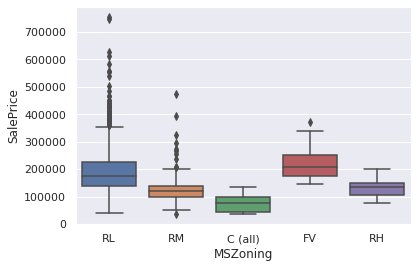

In [40]:
sns.boxplot(x='MSZoning', y='SalePrice', data=df)
plt.show()

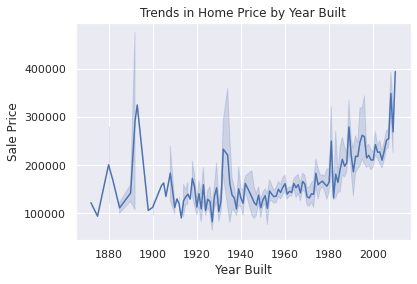

In [60]:
sns.lineplot(x='YearBuilt', y='SalePrice', data=df)
plt.xlabel('Year Built')
plt.ylabel('Sale Price')
plt.title('Trends in Home Price by Year Built')
plt.show()

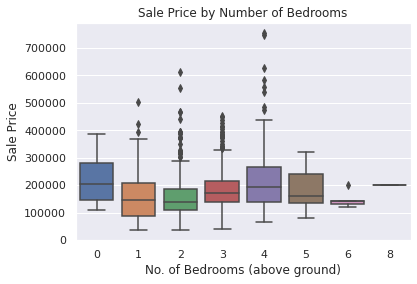

In [61]:
sns.boxplot(x='BedroomAbvGr', y='SalePrice', data=df)
plt.xlabel('No. of Bedrooms (above ground)')
plt.ylabel('Sale Price')
plt.title('Sale Price by Number of Bedrooms')
plt.show()

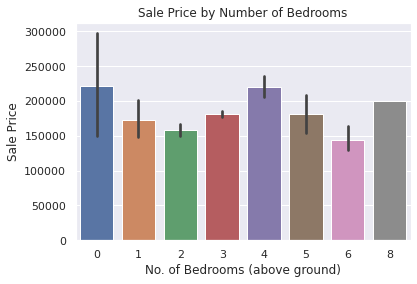

In [62]:
sns.barplot(x='BedroomAbvGr', y='SalePrice', data=df)
plt.xlabel('No. of Bedrooms (above ground)')
plt.ylabel('Sale Price')
plt.title('Sale Price by Number of Bedrooms')
plt.show()

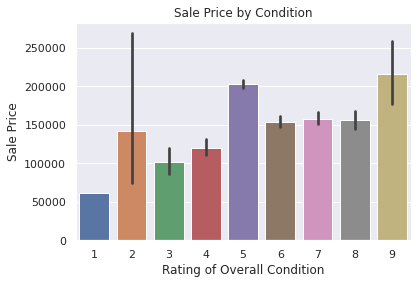

In [65]:
sns.barplot(x='OverallCond', y='SalePrice', data=df)
plt.xlabel('Rating of Overall Condition')
plt.ylabel('Sale Price')
plt.title('Sale Price by Condition')
plt.show()

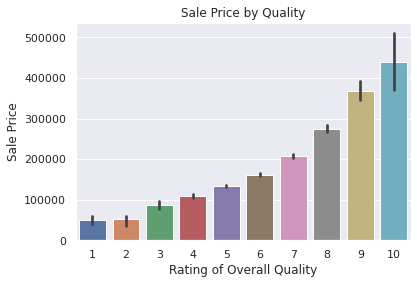

In [66]:
sns.barplot(x='OverallQual', y='SalePrice', data=df)
plt.xlabel('Rating of Overall Quality')
plt.ylabel('Sale Price')
plt.title('Sale Price by Quality')
plt.show()

Overall quality and total square footage seem to matter a lot, at least from what we can see with visualization. Overall condition matters as well. Those will be important to think about when we go to model the sale price. There also seems to be an upward trend in year build, but only for homes built after 1950 or so.

We should have a better feel for the data now. Let's start doing some statistics!